In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt
from scipy.stats import norm

import trials

In [3]:
T_outbound = 1500
h, v = trials.generate_route(T=T_outbound, vary_speed=True)

In [88]:
start_scope()

# Constants
N_TL2 = 16

# Neuron specification
El = -52 * mV # resting potential (mV)
Vt = -45 * mV # spike threshold (mV)
Vr = El       # reset potential (mV)

Cm = 0.002 * ufarad # membrane capacitance (uF)
Rm = 10 * Mohm      # membrane resistance (MOhm)
taum = Cm * Rm      # = 20ms membrane time constant (ms) 

#ge = 0 * mV # excitatory synaptic conductance ()
#gi = 0 * mV # inhibitory synaptic conductance ()
taue = 5 * ms # excitatory synaptic time constant (ms)
taui = 10 * ms # inhibitory synaptic time constant (ms)


eqs = '''
      dVm/dt  = ((El - Vm) + I_syn) / taum : volt
      I_syn = ge + gi : volt
      dge/dt = -ge/taue : volt
      dgi/dt = -gi/taui : volt
      '''
threshold_eqs = 'Vm >= Vt'
reset_eqs = 'Vm = Vr'

G_TL2 = NeuronGroup(N=N_TL2, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_TL2.Vm = Vr
G_TL2.ge = 0 * mV
G_TL2.gi = 0 * mV

In [89]:
def add_monitors(NG, variables_to_record=['Vm', 'ge', 'gi']):
    state_monitor = StateMonitor(NG, variables_to_record, record=True)
    spike_monitor = SpikeMonitor(NG)
    return state_monitor, spike_monitor

STM_TL2, SPM_TL2 = add_monitors(G_TL2)

In [90]:
we = (60 * 0.27 / 10) * mV
wi = (20 * 4.5 / 10) * mV

synapses_model = '''w : 1'''
synapses_eqs_ex = '''ge += we * w'''
synapses_eqs_in = '''gi += wi * w'''

In [91]:
#stimulus = TimedArray(np.tile([100., 0.], 2)*Hz, dt=100.*ms)
stimulus = TimedArray(100*h*Hz, dt=1500.*ms)

P = PoissonGroup(N_TL2, rates='stimulus(t)')
S = Synapses(P, G_TL2, model=synapses_model, on_pre=synapses_eqs_in)
S.connect(j='i')
S.w = 1

In [92]:
run(1500*ms)

In [93]:
def plot_stuff(M_spikes, M, name='', observation_list=[0]):
    figure(figsize=(10,7))
    #plotting spikes of cells on raster plot.
    subplot(2,2,1)
    title(f'{name} spikes')
    plot(M_spikes.t/ms, M_spikes.i, '.k')
    
    #observation_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    observation_list = observation_list

    #plotting voltage
    subplot(2,2,2)
    title('V')
    for i in observation_list:
        plot(M.t/ms, M.Vm[i])

    subplot(2,2,3)
    title('ge')
    for i in observation_list:
        plot(M.t/ms, M.ge[i])

    subplot(2,2,4)
    title('gi')
    for i in observation_list:
        plot(M.t/ms, M.gi[i])

    show()

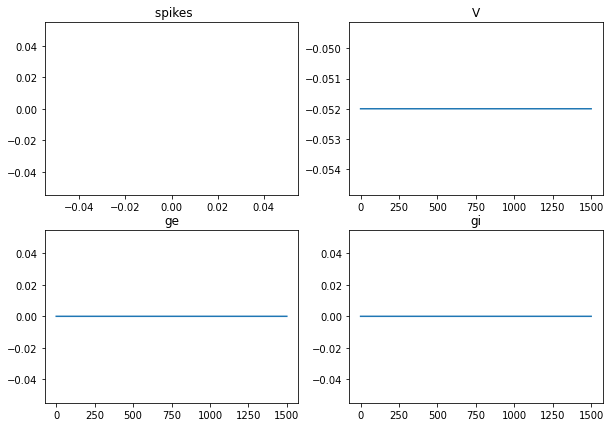

In [94]:
plot_stuff(SPM_TL2, STM_TL2, observation_list=[0])#,1,2,3])#,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

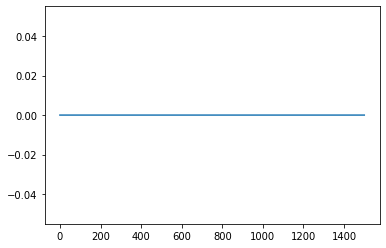

In [95]:
plot(STM_TL2.t / ms, stimulus(STM_TL2.t))

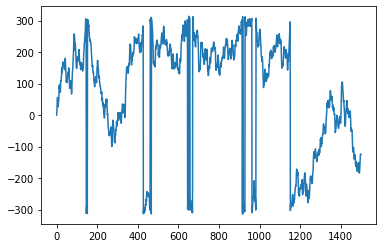

In [98]:
plt.plot(stimulus.values)

In [99]:
# Generate preferred orientations
tl2_prefs = np.tile(np.linspace(0, 2*np.pi, 8, endpoint=False), 2)

In [111]:
def compute_headings(h, N, loc=0, scale=0.8, vmin=5, vmax=100):
    rv = norm(loc=loc, scale=scale)
    x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), N, endpoint=True)
    pdf = rv.pdf(x)

    # Split the [-pi,pi] interval into bins
    bins = numpy.linspace(-np.pi, np.pi, N+1)
    # -1 required since the returned bins are 1-indexed
    digitized = numpy.digitize(h, bins) - 1
    
    headings = np.zeros((T_outbound,8))
    for t in range(T_outbound):
        angle_bin = digitized[t]
        headings[t,:] = numpy.roll(pdf, angle_bin)
        if t<40:
            print(h[t], digitized[t], angle_bin)
    
    # Normalize between 5-100 Hz, the headings represents rate
    if vmin > 0 and vmin > 0 and vmax > vmin:
        headings = ((headings - headings.min()) * (vmax - vmin)) / (headings.max() - headings.min()) + vmin
    
    return headings, digitized

In [112]:
headings, digitized = compute_headings(h, 8, vmin=5, vmax=30)

0.0 4 4
0.01781482207924112 4 4
0.15913872995766187 4 4
0.15808547872861656 4 4
0.11839049250556188 4 4
-0.03834363988609368 3 3
-0.13914053719079522 3 3
-0.02489296457465251 3 3
0.14609582475350136 4 4
0.24305643842807312 4 4
0.31608286025568866 4 4
0.46040164704687614 4 4
0.4066220021738518 4 4
0.23098045374412823 4 4
-0.05213727333504936 3 3
-0.3126687560461403 3 3
-0.3697438941493214 3 3
-0.506892480992776 3 3
-0.4359415858124076 3 3
-0.36054605584740784 3 3
-0.2754242048312152 3 3
-0.3037636558465153 3 3
-0.30410212104648826 3 3
-0.15508424680848432 3 3
-0.11127671450422305 3 3
0.003902626413573085 4 4
0.06683162466798498 4 4
0.144760640021671 4 4
0.17526958813375781 4 4
0.032195725797165675 4 4
-0.08898675990452753 3 3
-0.19001067564814988 3 3
-0.149912512512675 3 3
-0.0905775168001055 3 3
-0.09608947634302911 3 3
-0.26558754835634346 3 3
-0.23891692469836423 3 3
-0.13512199020899773 3 3
-0.008262507332174707 3 3
0.20959567185389583 4 4


0.0 0.01781482207924112


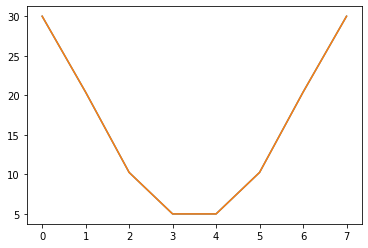

In [113]:
#rv = norm(loc=0, scale=0.8)
#x = np.linspace(rv.ppf(0.01), rv.ppf(0.99),  7, endpoint=True)
#pdf = np.append(rv.pdf(x), 0)
#plt.plot(pdf)
print(h[0], h[1])
plt.plot(headings[0,:])
plt.plot(headings[1,:])

In [101]:
start_scope()
time_step = 2
stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P = PoissonGroup(8, rates='stimulus(t,i)')
spike_monitor = SpikeMonitor(P)

In [102]:
run(T_outbound*time_step*ms)

In [103]:
len(spike_monitor.t/ms)

366

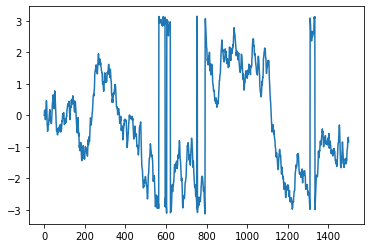

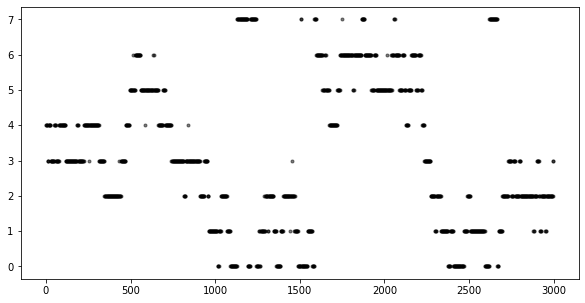

In [106]:
plt.plot(h)
plt.show()

figure(figsize=(10,5))
#plot(spike_monitor.t/ms, spike_monitor.i, '+r')
#print(np.linspace(0, 2, T_outbound*2).shape)
#print([0:100])
plot(np.array(range(0, T_outbound*2, 2, )), digitised, '.k', alpha=0.5)